Data ready.
Net ready.
Beginning training.
30 epochs passed.
60 epochs passed.
90 epochs passed.
Training finished.

Summary of training


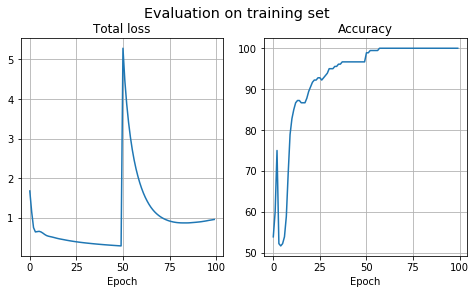

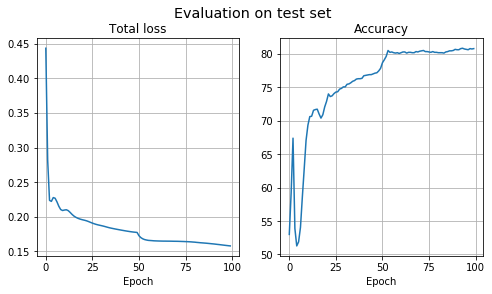

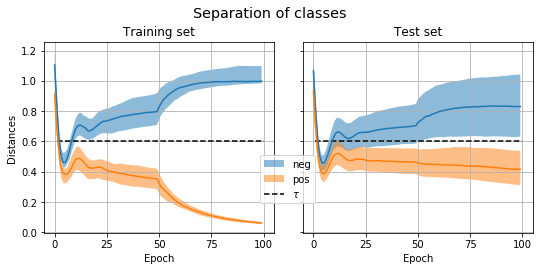

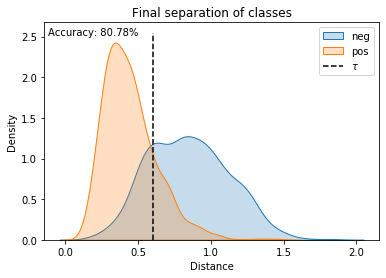

Maximal accuracy: 80.83% (epoch 93).


In [1]:
import itertools as it

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pl_blog.mnist import PseudolabelSNN
from data import SiameseMNIST as Dataset
from criterions import ContrastiveLoss

device = "cuda" if torch.cuda.is_available() else "cpu"


def test():
    train_log["pos_dists"].append([])
    train_log["neg_dists"].append([])
    test_log["total_loss"].append(0.0)
    test_log["pos_dists"].append([])
    test_log["neg_dists"].append([])

    net.eval()
    with torch.no_grad():
        # evaluation on training set
        correct = 0
        for tensors in train_loader:
            images1, images2, labels = (t.to(device) for t in tensors)
            outputs1, outputs2 = net(images1, images2)

            dists = F.pairwise_distance(outputs1, outputs2)
            preds = (dists <= T).float()
            correct += torch.isclose(labels.squeeze(), preds).sum().item()
            for label, dist in zip(labels, dists):
                if label.item() > 0.5:
                    train_log["pos_dists"][-1].append(dist.item())
                else:
                    train_log["neg_dists"][-1].append(dist.item())

        accuracy = 100 * correct / len(dataset.trainset)
        train_log["accuracy"].append(accuracy)

        # evaluation on test set
        correct = 0
        for tensors in test_loader:
            images1, images2, labels = (t.to(device) for t in tensors)
            outputs1, outputs2 = net(images1, images2)
            
            loss = criterion(outputs1, outputs2, labels.squeeze())
            test_log["total_loss"][-1] += loss.item()

            dists = F.pairwise_distance(outputs1, outputs2)
            preds = (dists <= T).float()
            correct += torch.isclose(labels.squeeze(), preds).sum().item()
            for label, dist in zip(labels, dists):
                if label.item() > 0.5:
                    test_log["pos_dists"][-1].append(dist.item())
                else:
                    test_log["neg_dists"][-1].append(dist.item())
        accuracy = 100 * correct / len(dataset.testset)
        test_log["accuracy"].append(accuracy)


def alpha(step):
    if step < S1:
        return 0
    elif step < S2:
        return (step - S1) / (S2 - S1) * max_alpha
    else:
        return max_alpha


# load data and prepare it
dataset = Dataset()
dataset.sample_traintest()
dataset.sample_unlabeled(20)

batch_size = 60
train_loader = torch.utils.data.DataLoader(dataset.trainset, batch_size=batch_size)
unlabeled_loader = torch.utils.data.DataLoader(dataset.unlabeled, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset.testset, batch_size=len(dataset.testset))
print("Data ready.")

# initialize net and optimizer
net = PseudolabelSNN().to(device)
criterion = ContrastiveLoss(margin=1.0)
T = 0.6
S1, S2 = 50, 125
max_alpha = 0.5
lr = 0.001
momentum = 0.9
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
print("Net ready.")

# training parameters
E = 100  # epochs

# logs
train_log = {
    "total_loss": [],  # total loss
    "accuracy": [],  # accuracy
    "pos_dists": [],  # predicted distances between positive pairs
    "neg_dists": [],  # predicted distances between negative pairs
}

test_log = {
    "total_loss": [],
    "accuracy": [],
    "pos_dists": [],
    "neg_dists": [],
}

print("Beginning training.")
# stage 1: only labeled
for i in range(min(E, S1)):
    if i != 0 and i % 30 == 0:
        print(f"{i} epochs passed.")

    # logs
    train_log["total_loss"].append(0.0)

    net.train()
    for tensors in train_loader:
        images1, images2, labels = (t.to(device) for t in tensors)
        outputs1, outputs2 = net(images1, images2)
        loss = criterion(outputs1, outputs2, labels.squeeze())

        train_log["total_loss"][-1] += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    test()

# stage 2: unlabeled + labeled for fine-tuning
t = S1
for i in range(S1, E):
    if i % 30 == 0:
        print(f"{i} epochs passed.")

    net.eval()
    with torch.no_grad():
        pseudo_labels = []
        for images1, images2 in unlabeled_loader:
            images1, images2 = images1.to(device), images2.to(device)
            outputs1, outputs2 = net(images1, images2)
            preds = (F.pairwise_distance(outputs1, outputs2) <= T).float()
            pseudo_labels.append(preds)
            
    net.train()
    train_log["total_loss"].append(0.0)
    count = 0
    for (images1, images2, labels), (images3, images4), p_labels in zip(it.cycle(train_loader), unlabeled_loader, pseudo_labels):
        images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)
        images3, images4 = images3.to(device), images4.to(device)
        
        outputs1, outputs2 = net(images1, images2)
        outputs3, outputs4 = net(images3, images4)
        loss = criterion(outputs1, outputs2, labels.squeeze()) + alpha(t) * criterion(outputs3, outputs4, p_labels)

        train_log["total_loss"][-1] += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        count += 1
        if count % len(train_loader) == 0:
            t += 0.02
            count = 0

    test()

print("Training finished.\n")

# summary - training
print("Summary of training")
start = 0  # the first epoch to be taken into consideration
k = 4
domain = range(start, E)
ticks = list(range(start, E + 1, (E - start) // k)) 

train_pos_dists = np.array(train_log["pos_dists"][start:])
train_neg_dists = np.array(train_log["neg_dists"][start:])
test_pos_dists = np.array(test_log["pos_dists"][start:])
test_neg_dists = np.array(test_log["neg_dists"][start:])

# on training set
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
fig.suptitle("Evaluation on training set", y=0.99, fontsize="x-large")

axs[0].plot(domain, train_log["total_loss"][start:])
axs[0].set(xlabel="Epoch", title="Total loss", xticks=ticks)
axs[0].grid()

axs[1].plot(domain, train_log["accuracy"][start:])
axs[1].set(xlabel="Epoch", title="Accuracy", xticks=ticks)
axs[1].grid()

plt.show()

# on test set
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True)
fig.suptitle("Evaluation on test set", y=0.99, fontsize="x-large")

axs[0].plot(domain, test_log["total_loss"][start:])
axs[0].set(xlabel="Epoch", title="Total loss", xticks=ticks)
axs[0].grid()

axs[1].plot(domain, test_log["accuracy"][start:])
axs[1].set(xlabel="Epoch", title="Accuracy", xticks=ticks)
axs[1].grid()

plt.show()

# separation of classes throughout training
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
fig.suptitle("Separation of classes", fontsize="x-large")

axs[0].set(title="Training set", xlabel="Epoch", ylabel="Distances", xticks=ticks)
axs[0].grid()

q25, q50, q75 = np.percentile(train_neg_dists, [25, 50, 75], axis=1)
axs[0].plot(domain, q50)
axs[0].fill_between(domain, q75, q25, alpha=0.5, label="neg")

q25, q50, q75 = np.percentile(train_pos_dists, [25, 50, 75], axis=1)
axs[0].plot(domain, q50)
axs[0].fill_between(domain, q75, q25, alpha=0.5, label="pos")

axs[0].hlines(T, start, E, label="$\\tau$", linestyles="--")

axs[1].set(title="Test set", xlabel="Epoch", xticks=ticks)
axs[1].grid()

q25, q50, q75 = np.percentile(test_neg_dists, [25, 50, 75], axis=1)
axs[1].plot(domain, q50)
axs[1].fill_between(domain, q75, q25, alpha=0.5)

q25, q50, q75 = np.percentile(test_pos_dists, [25, 50, 75], axis=1)
axs[1].plot(domain, q50)
axs[1].fill_between(domain, q75, q25, alpha=0.5)

axs[1].hlines(T, start, E, linestyles="--")

fig.tight_layout(pad=2.5)
fig.legend(loc=(0.482, 0.25))

plt.show()

# final model
plt.title("Final separation of classes")
sns.kdeplot(test_log["neg_dists"][-1], fill=True, label="neg")
sns.kdeplot(test_log["pos_dists"][-1], fill=True, label="pos")
plt.vlines(T, 0, plt.gca().get_ylim()[1], linestyles="--", label="$\\tau$")
plt.text(
    0.01,
    0.94,
    f"Accuracy: {test_log['accuracy'][-1]:.2f}%",
    transform=plt.gca().transAxes,
)
plt.xlabel("Distance")
plt.legend()
plt.show()

print(f"Maximal accuracy: {np.max(test_log['accuracy']):.2f}% (epoch {np.argmax(test_log['accuracy'])}).")
